In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sim_functions import *

from tqdm import tqdm

from scipy.optimize import curve_fit

Using numpy


In [2]:
nx = 100
ny = 100
steps = 5000
output_stride = 500

In [3]:
molecular_weights = xp.array([1,80])
n_species = len(molecular_weights)
multiplier = 13

Bss = multiplier * 1/np.sqrt(1/molecular_weights[0] + 1/molecular_weights[1])
D_lbm = 1/Bss
print('Predict diffusion constant = ', D_lbm)

phi_1 = 0.4
phi_2 = phi_1 * molecular_weights[0]/molecular_weights[1]
phis = xp.array([phi_1, phi_2])
print(phis)

predict_lambda = (phi_1 /3) * multiplier * 1/np.sqrt(1/molecular_weights[0] + 1/molecular_weights[0])
relaxation = predict_lambda/(1+predict_lambda/2)
viscosity_kinematic = 1/3 * (1/relaxation - 0.5)
print('viscosity_kinematic = ',viscosity_kinematic)

Predict diffusion constant =  0.07740235306730041
[0.4   0.005]
viscosity_kinematic =  0.27196414661021057


In [ ]:
v = 0.01
f0 = (9-5*phi_2)/4 -1.5*v

print('f0 = ',f0)

In [22]:
vx = 0.001
total_pressure = 1
partial_pressure = xp.array([0.98, 0.02])

ly = ny
y_coord = xp.linspace(0.0, ly, ny)
k = 2*xp.pi /ly
velocity_profile = xp.sin(k*y_coord) * vx

ux_s = xp.ones((n_species, nx, ny), dtype=xp.float32) * velocity_profile[None, None, :]
uy_s = xp.zeros((n_species, nx, ny), dtype=xp.float32)

rho_s = xp.zeros((n_species, nx,ny))
for s in range(n_species):
    rho_s[s,:,:] = 3* partial_pressure[s] * xp.ones((nx,ny))

f = xp.zeros((n_species, 9, nx, ny), dtype=DTYPE)
feq = equilibrium(f, rho_s, phis, ux_s, uy_s)
f = feq

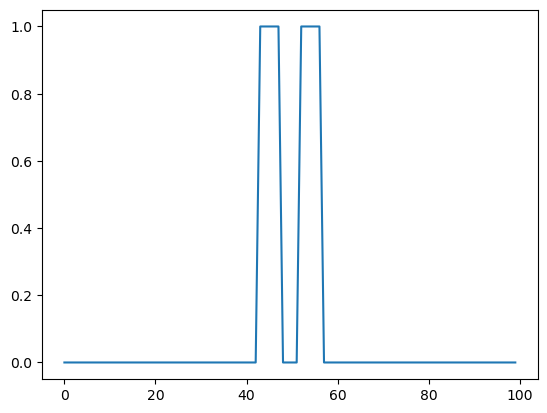

In [23]:
absorption_coefficient = 100

non_absorb_mask = xp.zeros(nx)
gap = 5
width = 5
non_absorb_mask[nx//2 - gap//2 - width: nx//2- gap//2] = True
non_absorb_mask[nx//2 + gap//2 : nx//2 + gap//2 + width] = True

plt.plot(to_numpy(non_absorb_mask))

In [24]:
#bottom boundary
b1 = xp.array([absorption_coefficient, 0, 0]) # 1 / absorption
b2 = xp.array([1, 1])
b3 = xp.array([0, 89.1])/2 # stable concentration
reflection_boundary = np.array([0, 1]) # which component has no-slip wall BC

bc_bottom = (b1, b2, b3, reflection_boundary)

# top boundary
b1 = xp.array([0, 0])
b2 = xp.array([1, 1])
b3 = xp.array([0.9, 89.1])/2
reflection_boundary = np.array([0, 0, 0])

bc_top = (b1, b2, b3, reflection_boundary)

In [25]:
def main(f):
    velocity_field = []
    for step in tqdm(range(steps + 1)):
        if step % output_stride == 0:
            
            rho_s, ux_s, uy_s, rho_mix, p_mix = calculate_moment(f, phis)
            print(np.max(ux_s), np.max(uy_s))
            ux_s = to_numpy(ux_s).astype(np.float32)
            uy_s = to_numpy(uy_s).astype(np.float32)
            velocity_field.append((ux_s, uy_s))
            
        if step == steps:
            break
        f = bgk_step(f, molecular_weights, phis, multiplier, lattice_stream, step, absorption_coefficient, 
                     non_absorb_mask, bc_top, bc_bottom)
        
    return np.array(velocity_field)

In [26]:
profiles = main(f)

  0%|          | 12/5001 [00:00<00:45, 110.81it/s]

0.0009998741276738847 9.440671907766586e-18


  7%|▋         | 370/5001 [00:02<00:36, 125.51it/s]


KeyboardInterrupt: 

In [19]:
velocity_field = profiles

In [20]:
print(velocity_field.shape)
# frames, components, species, nx, ny

vx_profile = velocity_field[:, 0, 0, nx//2, :]

(11, 2, 2, 100, 100)


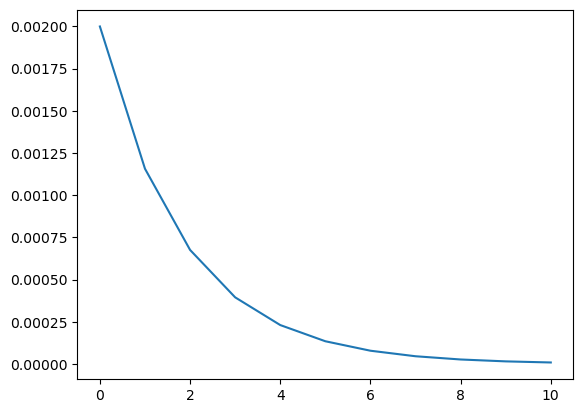

In [21]:
max_velocity_decay_profile = np.max(vx_profile, axis=1)
plt.plot(max_velocity_decay_profile)

In [58]:
ly = ny
k = 2*xp.pi /ly
i = len(max_velocity_decay_profile)-1
t = i * output_stride
mu = -np.log(max_velocity_decay_profile[i]/max_velocity_decay_profile[0])/(t* k**2)
print(mu)

0.287660163552931


0.29529092974378807


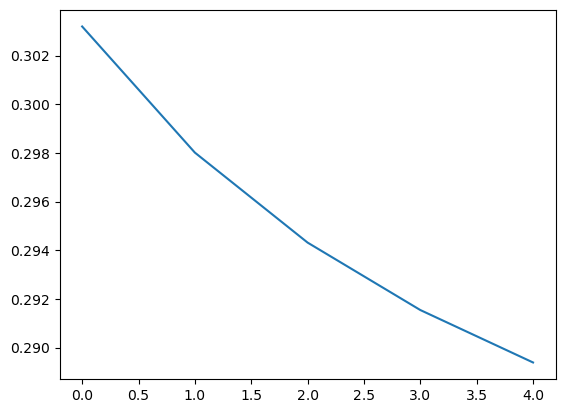

In [59]:
mu_lsit = []
for i in range(5, len(max_velocity_decay_profile)-1):
    t = i * output_stride
    mu = -np.log(max_velocity_decay_profile[i]/max_velocity_decay_profile[0])/(t* k**2)
    mu_lsit.append(mu)
plt.plot(mu_lsit)
print(np.mean(mu_lsit))